In [3]:
from sklearn.preprocessing import normalize
import json
import msacorrnet as mcn
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from scipy.spatial import distance
import random
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import f1_score
from sklearn.cluster import AgglomerativeClustering
from tqdm import trange

In [4]:
time = int(7200)

file = "data/hts-fault-2hr/cpu_usage.json"

f = open(file)

data = json.load(f)
f.close()

f_dict = {}
data = data['data']['result']
for ent in range(len(data)):
    if data[ent]['metric']['id'] != "/":
        f_dict[data[ent]['metric']['pod']] = np.zeros((len(data[ent]['values']), 2))
        f_dict[data[ent]['metric']['pod']][:, 0] = [float(x[0]) for x in data[ent]['values']]
        f_dict[data[ent]['metric']['pod']][:, 1] = [float(x[1]) for x in data[ent]['values']]

for service in f_dict:
    if data[0]["metric"]["__name__"] == "container_memory_usage_bytes":
        pass
    else:
        temp = [0]
        for i in range(1, np.shape(f_dict[service])[0]):
            temp.append(f_dict[service][i, 1] - f_dict[service][i - 1, 1])
        f_dict[service][:, 1] = deepcopy(temp)
        f_dict[service][:, 1] = mcn.sub_sample_zeros(f_dict[service][:, 1])

max_len = 0
for i in f_dict:
    if len(f_dict[i]) > max_len:
        max_len = len(f_dict[i])

aligned_data = mcn.align_data(f_dict, 5, time)
service_list = []
for s in aligned_data:
    service_list.append(s)
s_list = []
for s in aligned_data:
    s_list.append(s)
X = np.zeros((int((time / 5)), len(s_list)))
ind = 0
for s in service_list:
    X[:, ind] = aligned_data[s][:, 1]
    ind += 1
Xc = deepcopy(X)

import fnmatch

misc_ms = ["nginx*", "jaeger*"]
for ms in misc_ms:
    matched_indices = [index for index, string in enumerate(service_list) if fnmatch.fnmatchcase(string, ms)]
    for index in sorted(matched_indices, reverse=True):
        s_list.pop(index)
        service_list.pop(index)
        X = np.delete(X, index, axis=1)

# Set fault ground truth
ground_truth = np.zeros((X.shape[0] - 361, 1))
ground_truth[:360, 0] = 1

In [5]:
matched_indices = defaultdict(list)
pattern = re.compile(r'([a-zA-Z-]+)-[a-zA-Z0-9]+-[a-zA-Z0-9]+$')
for index, variable in enumerate(s_list):
    match = pattern.match(variable)
    if match:
        key = variable[:variable.rfind('-')]
        matched_indices[key].append(index)

In [6]:
# Hop proximity to faulty service (home-timeline-service)
zero_hop = ['home-timeline-service-65b4dd89b5']
one_hop = ['social-graph-service-5c666fc6c5', 'compose-post-service-67b44dc876', 'post-storage-service-6b6b494569', 'home-timeline-redis-5774f4dfdc']
two_hop = ['post-storage-memcached-5c48bc889d','user-timeline-service-5b876bb6df','text-service-74b97bd879','user-service-655ff546f9','media-service-7ddd74bccb','unique-id-service-7c78b5cc7b','social-graph-redis-7887fc84fb']
three_hop = ['post-storage-mongodb-7bf4f76c65','media-memcached-7dfb74bc7d','media-frontend-77cd978649','user-memcached-7f646b6586','social-graph-mongodb-bc8595d6f','user-timeline-redis-6b775dbddc', 'url-shorten-service-7cdf5f9c88']
four_hop = ['user-mention-service-67b9c5f949','media-mongodb-785b655677','user-timeline-mongodb-6cd9d5b79d','url-shorten-memcached-dcf8457d','user-mongodb-7f696dfb48']
five_hop = ['url-shorten-mongodb-5cf6bd4d78']

prox_dict = {0: zero_hop, 1: one_hop, 2: two_hop, 3: three_hop, 4: four_hop, 5: five_hop}

In [8]:
matched_indices = defaultdict(list)
for index, variable in enumerate(s_list):
    match = pattern.match(variable)
    if match:
        key = variable[:variable.rfind('-')]
        matched_indices[key].append(index)
            
f1_scores = {}
np.seterr(divide='ignore', invalid='ignore')
for n in trange(0,50):
    Xc = deepcopy(X)
    Xdiff = np.diff(Xc[:, :], axis=0)
    Xdiff = normalize(Xdiff, axis=0)
    
    win = 360
    step = 1
    r_dict = mcn.rolling_window(Xdiff[:, :], win, "tapered", step, 0.3, False, "pearsons")
    
    r_pos = {}
    for corr in r_dict:
        r_pos[corr] = deepcopy(r_dict[corr])
        r_pos[corr] = r_pos[corr] + 1
    
    spectra = mcn.all_spectra(r_pos, True)
    all_es = spectra.T
    all_es = all_es[:, :-1]
    scaling = "LMDS"
    if scaling == "LMDS":
        landmarks = random.sample(range(0, all_es.shape[0], 1), int(len(all_es) / 4))
        dist = distance.cdist(all_es[landmarks, :], all_es, 'euclidean')
        coords = mcn.LMDS(dist, landmarks, 2)
    
    clustering = AgglomerativeClustering(n_clusters=2, linkage="average").fit(coords)
    labels = clustering.labels_
    conf_matrix = confusion_matrix(ground_truth, labels)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    labels_adjusted = np.zeros_like(labels)
    for i, j in zip(row_ind, col_ind):
        labels_adjusted[labels == j] = i
    
    f1 = f1_score(ground_truth, labels_adjusted)
    if n == 0:
        f1_scores[1] = [f1]
    else:
        f1_scores[1].append(f1)
    rm_inds = []
    prox_dict_cp = deepcopy(prox_dict)
    for prx in prox_dict_cp:
        for _ in range(len(prox_dict_cp[prx])):
            ms = random.choice(prox_dict_cp[prx])
            prox_dict_cp[prx].remove(ms)
            rm_inds.extend(matched_indices[ms])
            # matched_indices.pop(ms)

            X_reduced = np.delete(Xc, rm_inds, axis=1)
            # if 2 or fewer variables we can't project to 2D space
            if X_reduced.shape[1] <= 1:
                break
                
            Xdiff = np.diff(X_reduced[:, :], axis=0)
            Xdiff = normalize(Xdiff, axis=0)

            win = 360
            step = 1
            r_dict = mcn.rolling_window(Xdiff[:, :], win, "tapered", step, 0.3, False, "pearsons")

            r_pos = {}
            for corr in r_dict:
                r_pos[corr] = deepcopy(r_dict[corr])
                r_pos[corr] = r_pos[corr] + 1

            spectra = mcn.all_spectra(r_pos, True)
            all_es = spectra.T
            all_es = all_es[:, :-1]

            landmarks = random.sample(range(0, all_es.shape[0], 1), int(len(all_es) / 4))
            dist = distance.cdist(all_es[landmarks, :], all_es, 'euclidean')
            try:
                coords = mcn.LMDS(dist, landmarks, 2)
            except:
                break

            clustering = AgglomerativeClustering(n_clusters=2, linkage="average").fit(coords)
            labels = clustering.labels_
            conf_matrix = confusion_matrix(ground_truth, labels)
            row_ind, col_ind = linear_sum_assignment(-conf_matrix)
            labels_adjusted = np.zeros_like(labels)
            for i, j in zip(row_ind, col_ind):
                labels_adjusted[labels == j] = i

            f1 = f1_score(ground_truth, labels_adjusted)
            if X_reduced.shape[1]/X.shape[1] in f1_scores:
                f1_scores[X_reduced.shape[1]/X.shape[1]].append(f1)
            else:
                f1_scores[X_reduced.shape[1]/X.shape[1]] = [f1]

100%|██████████| 50/50 [09:17<00:00, 11.15s/it]


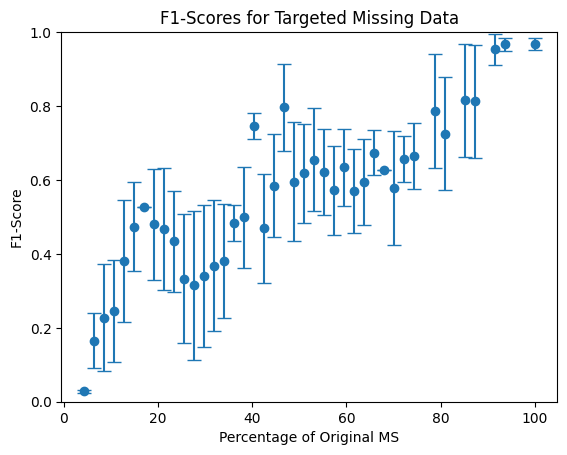

In [9]:
n_ms = []
f1_means = []
f1_stds = []
for x_val, y_vals in f1_scores.items():
    n_ms.append(x_val*100)
    f1_means.append(np.mean(y_vals))
    f1_stds.append(np.std(y_vals))
    
plt.errorbar(n_ms, f1_means, yerr=f1_stds, fmt='o', capsize=5)

plt.xlabel('Percentage of Original MS')
plt.ylabel('F1-Score')
plt.title('F1-Scores for Targeted Missing Data')
plt.ylim(0,1)
plt.show()

In [10]:
for i in trange(0,50):
    matched_indices = defaultdict(list)
    for index, variable in enumerate(s_list):
        match = pattern.match(variable)
        if match:
            key = variable[:variable.rfind('-')]
            matched_indices[key].append(index)
    rm_inds = []
    while len(matched_indices) > 0:
        ms_ind = random.randint(0, len(matched_indices)-1)
        rm_inds.extend(matched_indices[list(matched_indices.keys())[ms_ind]])
        del matched_indices[list(matched_indices.keys())[ms_ind]]
        X_reduced = np.delete(X, rm_inds, axis=1)
        # if 2 or less variables we can't project to 2D
        if X_reduced.shape[1] <= 1:
            break
        Xc = X_reduced
        Xdiff = np.diff(Xc[:, :], axis=0)
        Xdiff = normalize(Xdiff, axis=0)
    
        win = 360
        step = 1
        r_dict = mcn.rolling_window(Xdiff[:, :], win, "tapered", step, 0.3, False, "pearsons")
    
        r_pos = {}
        for corr in r_dict:
            r_pos[corr] = deepcopy(r_dict[corr])
            r_pos[corr] = r_pos[corr] + 1
    
        spectra = mcn.all_spectra(r_pos, True)
        all_es = spectra.T
        all_es = all_es[:, :-1]
    
        landmarks = random.sample(range(0, all_es.shape[0], 1), int(len(all_es) / 4))
        dist = distance.cdist(all_es[landmarks, :], all_es, 'euclidean')
        try:
            coords = mcn.LMDS(dist, landmarks, 2)
        except:
            f1_scores[X_reduced.shape[1]/X.shape[1]] = [0]
            break
    
        clustering = AgglomerativeClustering(n_clusters=2).fit(coords)
        labels = clustering.labels_
        conf_matrix = confusion_matrix(ground_truth, labels)
        row_ind, col_ind = linear_sum_assignment(-conf_matrix)
        labels_adjusted = np.zeros_like(labels)
        for i, j in zip(row_ind, col_ind):
            labels_adjusted[labels == j] = i
        
        f1 = f1_score(ground_truth, labels_adjusted)
        if X_reduced.shape[1]/X.shape[1] in f1_scores:
            f1_scores[X_reduced.shape[1]/X.shape[1]].append(f1)
        else:
            f1_scores[X_reduced.shape[1]/X.shape[1]] = [f1]

100%|██████████| 50/50 [09:59<00:00, 11.98s/it]


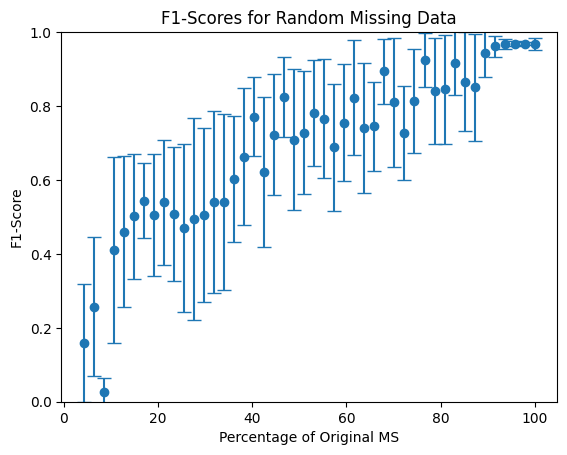

In [11]:
n_ms = []
f1_means = []
f1_stds = []
for x_val, y_vals in f1_scores.items():
    n_ms.append(x_val*100)
    f1_means.append(np.mean(y_vals))
    f1_stds.append(np.std(y_vals))
    
plt.errorbar(n_ms, f1_means, yerr=f1_stds, fmt='o', capsize=5)

plt.xlabel('Percentage of Original MS')
plt.ylabel('F1-Score')
plt.title('F1-Scores for Random Missing Data')
plt.ylim(0,1)
plt.show()